# Fact Verification and Extraction of Climate-Related Claims

This is the main notebook for my repository. All inference functions are called in this notebook. Helper functions are found in the *.py* files. The model training is conducted in the *.ipynb* files.

Please see the *README.md* file and the associated report for further explanation.

# Preliminary

### Imports

In [1]:
import json
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from enum import Enum

### Arguments

An Arguments object which sets the parameters for the inferences. Change 'mode' to TEST to perform inferences on the test set. DEV will perform inferences on the DEV set.

In [2]:
class Mode(Enum):
    DEV = 1
    TEST = 2

class Arguments():
    mode = Mode.TEST    #'Mode.TEST' = infer on test set. 'Mode.DEV' = infer on dev set.
    ev_path='./data/evidence.json'
    ev_pickle='./pickles/evidence.pkl'
    rank_top_n = 500
    shortlist_model_name = 'distilbert-base-cased'
    er_model_name = 'roberta-large'
    er_save_dir = './models/evidence_ranking_trained_model'
    cc_model_name = 'roberta-large-mnli'
    cc_save_dir = './models/claim_classification_trained_model'
    claims_path = './data/dev-claims.json'
    claims_pickle = './pickles/dev_claims.pkl'
    claims_predictions = './output/dev-claims-predictions.json'

    def dev_mode(self):
        return True if self.mode == Mode.DEV else False

my_args = Arguments()

if my_args.mode == Mode.TEST:
    my_args.claims_path = './data/test-claims-unlabelled.json'
    my_args.claims_pickle = './pickles/test_claims.pkl'
    my_args.claims_predictions = './output/test-claims-predictions.json'


# A. Shortlisting

### Training

There is no training / finetuning required in this step.

### Inference

This section calls all the inference functions for the Shortlisting step. Please see *A_shortlisting.py* for methods.

In [4]:
from A_shortlisting import build_evidence, save_evidence, load_evidence, build_claims, save_claims, load_claims, get_top_10k_splices_recall, plot_counts

shortlist_model_name = my_args.shortlist_model_name
shortlist_tokenizer = AutoTokenizer.from_pretrained(shortlist_model_name)
shortlist_model = AutoModel.from_pretrained(shortlist_model_name).to('cuda')

# Build evidence dataframe with feature sets
evidence = build_evidence(shortlist_model, shortlist_tokenizer, path=my_args.ev_path)

# Save evidence dataframe to pickle for future use
save_evidence(evidence, my_args.ev_pickle)

# Build claim dataframe with feature sets and top 10k evidence lists
claims = build_claims(shortlist_model, shortlist_tokenizer, evidence, path=my_args.claims_path, dev_mode=my_args.dev_mode())

# Save claims dataframe to pickle for future use
save_claims(claims, my_args.claims_pickle)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Reading claims from ./data/test-claims-unlabelled.json
Generating embeddings...


100%|██████████| 1/1 [00:05<00:00,  6.00s/it]


Extracting nouns and entities...


100%|██████████| 153/153 [00:00<00:00, 437.33it/s]


Getting top_10k_embeddings...


100%|██████████| 153/153 [00:04<00:00, 33.41it/s]


Getting top_10k_nouns...


100%|██████████| 153/153 [02:07<00:00,  1.20it/s]


Getting top_10k consolidated list...


100%|██████████| 153/153 [01:21<00:00,  1.88it/s]


Number of claims:  153
Saving claims to pickle...done.


##### (DEV mode only) Metrics and analysis on dev set

Analysing recall...
Total recalled in top_10k_consolidated: 438 / 491 = 0.892057
defaultdict(None, {'0-500': 305, '500-1000': 35, '1000-1500': 25, '1500-2000': 18, '2000-2500': 19, '2500-3000': 8, '3000-3500': 10, '3500-4000': 10, '4000-4500': 3, '4500-5000': 5})
Analysing recall...
Total recalled in top_10k_embeddings: 383 / 491 = 0.780041
defaultdict(None, {'0-500': 223, '500-1000': 54, '1000-1500': 27, '1500-2000': 24, '2000-2500': 19, '2500-3000': 13, '3000-3500': 9, '3500-4000': 9, '4000-4500': 2, '4500-5000': 3})
Analysing recall...
Total recalled in top_10k_nouns: 371 / 491 = 0.755601
defaultdict(None, {'0-500': 251, '500-1000': 42, '1000-1500': 29, '1500-2000': 11, '2000-2500': 10, '2500-3000': 7, '3000-3500': 8, '3500-4000': 6, '4000-4500': 4, '4500-5000': 3})


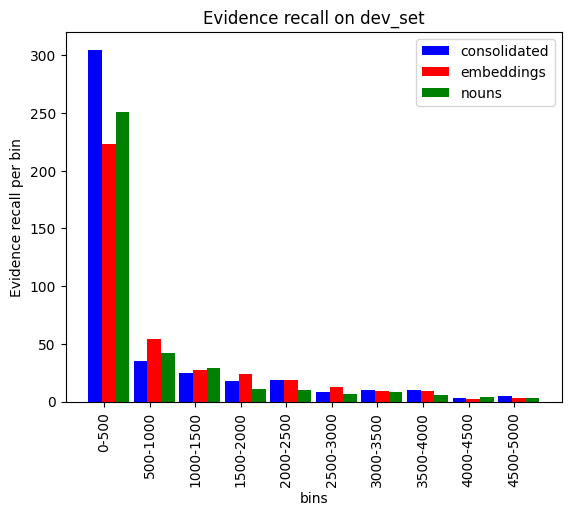

<Figure size 400x400 with 0 Axes>

In [11]:
if my_args.mode == Mode.DEV:
    total_width = 5000
    consolidated = get_top_10k_splices_recall(claims, bin_width=500, dev_mode=my_args.dev_mode(), col_name='top_10k_consolidated', total_width=total_width)
    print(consolidated)
    embeddings = get_top_10k_splices_recall(claims, bin_width=500, dev_mode=my_args.dev_mode(), col_name='top_10k_embeddings', total_width=total_width)
    print(embeddings)
    noun_entity = get_top_10k_splices_recall(claims, bin_width=500, dev_mode=my_args.dev_mode(), col_name='top_10k_nouns', total_width=total_width)
    print(noun_entity)
    plot_counts(consolidated, embeddings, noun_entity)
else:
    print("Cannot provide metrics in TEST mode.")

# B. Evidence Ranking

### Training

The evidence ranking model needs to be trained / finetuned **prior** to inference. Please see *B_evidence_ranking_training.ipynb* for training methods. Note that the evidence shortlists built in step A (above), and the claims dataframes (below) must be complete in order to train this model, because the hard negative mining instances select from the ranked evidence list. Training will save trained model weights into /models subfolder, which are then accessed by the methods called below.

If the kernel has been reset since running the shortlisting step, above, the model and evidence objects can be reloaded by un-commenting the code in the cell below:

In [ ]:
# # Load models, and evidence from pickle (if kernel has been reset since running Shortlisting, above):
# from A_shortlisting import load_evidence
# shortlist_model_name = my_args.shortlist_model_name
# shortlist_tokenizer = AutoTokenizer.from_pretrained(shortlist_model_name)
# shortlist_model = AutoModel.from_pretrained(shortlist_model_name).to('cuda')
# evidence = load_evidence(my_args.ev_pickle)

In [6]:
# Build and save claims dataframe for dev and train sets only (for hard negative mining during training of Evidence Ranking model):
er_dev_claims = build_claims(shortlist_model, shortlist_tokenizer, evidence, path='./data/dev-claims.json', dev_mode=True)
save_claims(er_dev_claims, './pickles/er_dev_claims.pkl')
er_train_claims = build_claims(shortlist_model, shortlist_tokenizer, evidence, path='./data/train-claims.json', dev_mode=True)
save_claims(er_train_claims, './pickles/er_train_claims.pkl')

Reading claims from ./data/dev-claims.json
Generating embeddings...


100%|██████████| 1/1 [00:04<00:00,  4.87s/it]


Extracting nouns and entities...


100%|██████████| 154/154 [00:07<00:00, 20.74it/s]


Getting top_10k_embeddings...


100%|██████████| 154/154 [00:04<00:00, 34.12it/s]


Getting top_10k_nouns...


100%|██████████| 154/154 [02:07<00:00,  1.21it/s]


Getting top_10k consolidated list...


100%|██████████| 154/154 [01:21<00:00,  1.90it/s]


Number of claims:  154
Saving claims to pickle...done.
Reading claims from ./data/train-claims.json
Generating embeddings...


100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


Extracting nouns and entities...


100%|██████████| 1228/1228 [00:02<00:00, 539.85it/s]


Getting top_10k_embeddings...


100%|██████████| 1228/1228 [00:39<00:00, 30.91it/s]


Getting top_10k_nouns...


100%|██████████| 1228/1228 [24:22<00:00,  1.19s/it]


Getting top_10k consolidated list...


100%|██████████| 1228/1228 [18:34<00:00,  1.10it/s]


Number of claims:  1228
Saving claims to pickle...done.


NOW, GO TO -> *B_evidence_ranking_training.ipynb* -> before continuing

### Inference

This section calls the inference functions for the Evidence Ranking step. Please see *B_evidence_ranking.py* for methods. If the kernel has been reset since running Shortlisting step, above, the evidence and claims objects can be loaded from pickle by un-commenting the code in the following cell:

In [4]:
# # Load evidence and claims from pickle (if kernel has been reset since running Shortlisting, above):
# from A_shortlisting import load_evidence, load_claims
# evidence = load_evidence(my_args.ev_pickle)
# claims = load_claims(my_args.claims_pickle)

In [5]:
from B_evidence_ranking import add_top_5, get_top_5_recall

ranking_save_dir = my_args.er_save_dir
ranking_tokenizer = AutoTokenizer.from_pretrained(my_args.er_model_name, device='cuda')
ranking_model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=ranking_save_dir).to('cuda')

# Rank the shortlist evidences for each claim and add the top_5 to the dataframe
claims = add_top_5(claims, evidence, ranking_model, ranking_tokenizer, N=my_args.rank_top_n)

# Save claims dataframe for future use:
save_claims(claims, my_args.claims_pickle)

Adding top 5 evidences to claims...


100%|██████████| 153/153 [21:06<00:00,  8.28s/it]


Saving claims to pickle...done.


##### (DEV mode only) Metrics and analysis on dev set

In [8]:
if my_args.mode == Mode.DEV:
    get_top_5_recall(claims, my_args.dev_mode())
else:
    print("Cannot provide metrics in TEST mode.")

TOTAL RECALL: 138 / 491


# C. Claim Classification

### Training

The claim classification model needs to be trained / finetuned **prior** to inference. Please see *C_claim_classification_training.ipynb* for training methods. Training will save trained model weights into /models subfolder, which are then accessed by the methods called below.

GO TO -> *C_claim_classification_training.ipynb* -> before continuing

### Inference

This section calls the inference functions for the Claim Classification step. It classifies each evidence-claim pair, assigns a label to the claim and selects the final evidence set. Please see *C_claim_classification.py* for methods. If the kernel has been reset since running the Evidence Ranking step, above, the evidence and claims objects can be loaded from pickle by un-commenting the code in the following cell:

In [5]:
# Load evidence and claims from pickle (if kernel has been reset since running Evidence Ranking, above):
# from A_shortlisting import load_evidence, save_claims, load_claims
# evidence = load_evidence(my_args.ev_pickle)
# claims = load_claims(my_args.claims_pickle)

Loading evidence from pickle...done.
Loading claims from pickle...done.


In [6]:
classifier_save_dir = my_args.cc_save_dir
classifier_tokenizer = AutoTokenizer.from_pretrained(my_args.cc_model_name, device='cuda')
classifier_model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=classifier_save_dir).to('cuda')

from C_claim_classification import add_classifications

# Run the classifier to add label to individual claim-ev top5 pairs, assign overall label and append final evidence set to claim dataframe:
claims = add_classifications(claims, evidence, classifier_model, classifier_tokenizer)

# Save claims dataframe
save_claims(claims, my_args.claims_pickle)

Adding final classifications to claims:
Getting labels for top_5...


100%|██████████| 153/153 [00:16<00:00,  9.21it/s]


Getting predictions based on top_5 labels:...done.
Saving claims to pickle...done.


##### (DEV mode only) Metrics

In [7]:
if my_args.mode == Mode.DEV:
    from C_claim_classification import get_evidences_pred_recall, get_accuracy, get_confusion_matrix
    get_evidences_pred_recall(claims, my_args.dev_mode())
    get_accuracy(claims, my_args.dev_mode())
    get_confusion_matrix(claims, my_args.dev_mode())
else:
    print("Cannot provide metrics in TEST mode.")

TOTAL RECALLED  : 120 / 491 (0.244399)
TOTAL PREDICTED : 555
Claim label prediction accuracy: 0.538961
Confusion matrix:
     D  NEI  R   S
D    7    1  1   9
NEI  5   10  6  20
R    9    4  9   5
S    8    1  2  57


# Export & Evaluation

This section builds the output json file for final evaluation. The export is found in ./output subfolder. The claims object can be retrieved from the Claim Classification step by un-commenting the code in the first cell.

In [ ]:
# # Load claims from pickle (if kernel has been reset since running Claim Classification, above):
# claims = load_claims(my_args.claims_pickle)

In [7]:
from D_export_eval import build_predictions_json

# Build output json file
build_predictions_json(claims, my_args.claims_predictions)

Saved predictions to ./output/test-claims-predictions.json


In [10]:
# # Run eval.py script when in dev mode:
# %run ./eval.py --predictions "./output/dev-claims-predictions.json" --groundtruth "./data/dev-claims.json"

Evidence Retrieval F-score (F)    = 0.22514945372088233
Claim Classification Accuracy (A) = 0.538961038961039
Harmonic Mean of F and A          = 0.3176158020628844
